# AcreValue Coding Challenge

**Granular Take Home Challenge**

_François Paupier - Saturday, 18th August 2018_ 

## Goal

In this notebook I present my work to build an agricultural land valuation model. The objective is to obtain a model which is able to predict the price-per-area of a parcel of land. 


_Note_: I followed the proposed task order to build my valuation model.

## (1) Dataset exploration and building the feature of interest

Import packages once and for all

In [131]:
import os

import fiona
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import rasterio
import shapely

from rasterio import mask
from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry.polygon import LinearRing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


plotly.offline.init_notebook_mode(connected=True)

### Exploring the scalars attributes of the parcels

First, I use `fiona` CLI: `fio` to get some insights on the shapefile data structure.  `fio info parcels_exam.shp` was pretty handy. 

---

I browse all parcels in the shapefile and I create a `price_per_area` feature defined as:
$$price\_per\_area =  \frac{tot\_price}{area}$$

In [132]:
series = {}
with fiona.open('parcels_exam.shp') as raw_parcels_data:
    for parcel in raw_parcels_data:
        
        # Get data and build `price_per_area` feature
        parcel_data = parcel['properties']
        price_per_area = parcel_data.get('tot_price') / parcel_data.get('area')
        parcel_data['price_per_area'] = price_per_area
        
        # Update the series dict
        key = parcel_data.get('_id')
        series[key] = pd.Series(parcel_data)
    
parcels_data = pd.DataFrame(series).transpose()

_A quick check that the data are correctly loaded_

In [133]:
parcels_data.head(3)

_id           area     water   ponding   organic     slope       gdd  \
0  0.0  212202.777883  0.470132  0.716075  0.287991  0.383462  0.749170   
1  1.0  115054.634691  0.311945  0.398221  0.209844  0.186193  0.944372   
2  2.0  308655.040738  0.555649  0.009240  0.833038  0.984329  0.703495   

       road     tot_price  price_per_area  
0  0.878452  2.096351e+07           98.79  
1  0.739551  6.928590e+06           60.22  
2  0.181631  3.277608e+07          106.19

### Data visualization of parcels `price_per_area` distribution

Let's consider a basic histogram of the `price_per_area` repartition.

In [137]:
data = [
        go.Histogram(
            x=parcels_data.price_per_area,
            y=parcels_data._id,
            )
        ]

layout = go.Layout(
    title="Distribution of the price per area for a parcel of land",
    xaxis=dict(
        title='price_per_area',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        ),
    ),
    yaxis=dict(
        title='Parcel count',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        ),
    )
)

plotly.offline.iplot({
    "data": data,
    "layout": layout
})

We notice that the `price_per_area` distribution in the parcels dataset may be approximated by a Gaussian - 500 data points may not be enough for an exact density estimation but it can give us some insights.

## (2) A baseline model to estimate the price-per-area of a parcel of land

_A priori_, a linear regression seems to be a good enough model to estimate the price-per-area of a parcel of land. This is a supervized learning context and we need to estimate a continuous value from a (quite small) set of features.

Let's define $X$ as our features and $Y$ as the value we want to estimate.

Since the `price_per_area` is a feature engineered from existing ones, it is directly correlated with the `tot_price` and with `area`. It doesn't make sense to build a regression model if the expected value is simply one of the features divided by another one.

Hence, we should remove either `tot_price` or `area` from $X$.


---

The goal of our product is to empower farmers with a fair estimation of their lands.

We want them to be able to estimate their land price from the area they own (on top of other features - `gdd`, `slope`, ... ).
That means that we will be provided with an `area` and from the `price_per_area` value we provide farmers they will decide the `tot_price` of their lands.


Thus, we remove the `tot_price` feature from $X$.

We keep the `area` feature but perform a _min-max_ normalization to work with a set of features within $[0, 1]$.

$$area' = \frac{\text{area}-min(\text{area})}{max(\text{area})-min(\text{area})}$$

In [5]:
X = parcels_data.drop(['_id', 'price_per_area', 'tot_price'], axis=1)
X.area = (X.area - np.min(X.area))/(np.max(X.area) - np.min(X.area))
Y = parcels_data.price_per_area

500 data points is not a huge dataset and we must pay attention to the risk of overfitting.

Let's train different linear regressions with an increasing number of items in the training set and compare each model score and mean squared error.

In [168]:
squared_errors = []
scores = []

train_set_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9, 0.95, 0.98]

for train_percent in train_size:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_percent)
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # Compute training metrics
    squared_errors.append(mean_squared_error(y_test, y_pred))
    scores.append(r2_score(y_test, y_pred))

In [169]:
data = [
        go.Scatter(
            x=train_size,
            y=scores,
            mode='markers'
            )
        ]
layout = go.Layout(
    title="Score evolution in function of training set size",
    xaxis=dict(
        title='Percentage of parcels used for the training set',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        ),
    ),
    yaxis=dict(
        title='Score',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='lightgrey'
        ),
    )
)
plotly.offline.iplot({
    "data": data,
    "layout": layout
})

We notice that the model accuracy drops when we use more than 90% of the dataset as a training set.
Using 90% or more of the dataset as training set seems to lead to a high variance model prone to overfitting.


Thus, the baseline model that we use as an estimator of `price_per_area` is a linear regression trained with 90% of the available data. It is very likely that we have a highly biased model, meaning it does not really fit the data. ($\approx 0.5$ for $r²$ score is a poor performance)

In [170]:
train_size = 0.9

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_size)
baseline_estimator = linear_model.LinearRegression()
baseline_estimator.fit(X_train, y_train)
y_pred = baseline_estimator.predict(X_test)

# Compute the error of the baseline model
baseline_mse = mean_squared_error(y_test, y_pred)
baseline_score = r2_score(y_test, y_pred)

print('baseline estimator\n mean squarred error: %0.f \n r2 score: %0.03f' % (baseline_mse, baseline_score))


baseline estimator
 mean squarred error: 124 
 r2 score: 0.580


## (3) Consider parcel's geometry in the valuation model

On top of scalar values considered when building the baseline estimator, we now want to consider the parcel geometry to increase our model accuracy.

The `readme.md` provided with the challenge indicates that "more convex" parcels are sold at a higher price. Hence, the business reality tells us that the `convexness` and the `price_per_area` to be positively correlated.

Before engineering a `convexness` feature, let's dive into the dataset to understand those geometric data.

---


### Extracting the geometric data from the shapefiles

The first step is to access the parcels geometric data. Again, the `fiona` CLI helped me to understand the way the geometric data is structured for a parcel.

```shell
$ fio dump --indent 2 parcels_exam.shp
```

We notice that for each parcel, among its `features`, there is a `geometry` value. `geometry` is also a dictionnary with a `coordinates` and a `type` key.

After a quick analysis of the shapefile, I noticed that there are two types of geometry `type` : `Polygon` and `MultiPolygon`. 

The `coordinates` is a `list[list[tuple(float, float]]`. 

 - For `Polygon` the `coordinates` list is only of size one - one polygon.
 - For `MultiPolygon` the `coordinates` list has a `lenght > 1` - each item (which is a list of coordinates) defines the coordinates of one polygon.
 
**Now, what does it mean for one parcel to have multiple polygons ?**

_Possible explanation_
 
1. The available geospatial resolution makes us mistake consider a narrow path within the parcel as a point, thus creating multiple polygon.
2. A parcel is split in disjoint sub-parcels (may be due to the presence of public lakes, forests, etc that do not belong to the land owner)

Let's consider a few examples of `MultiPolygon` to better understand the data


In [171]:
multi = []
with fiona.open('parcels_exam.shp') as raw_parcels_data:
     for parcel in raw_parcels_data:
        geometry = parcel['geometry']
        
        # Consider only the MultiPolygon geometry
        if geometry.get('type') == 'MultiPolygon':
            polygons = []
            coords = geometry.get('coordinates')
            for shape in coords:
                polygons.append(Polygon(shape[0]))
            multi_polygon = MultiPolygon(polygons)
            multi.append(multi_polygon)
            

In [172]:
len(multi)

103

The following `MultiPolygon` asserts the hypothesis 1. A narrow path between the two sub-parcels is mistaken for a point, thus multiple polygon are considered for a single parcel.

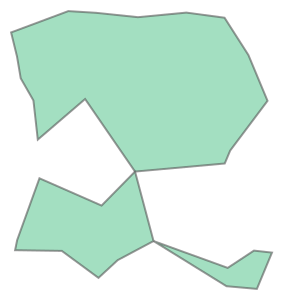

In [11]:
multi[101]

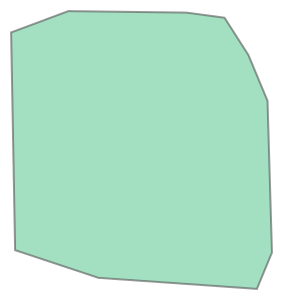

In [12]:
multi[101].convex_hull

The `MultiPolygon` `multi[8]` is an example of a parcel being a set of sub-parcels. It asserts hypothesis 2.

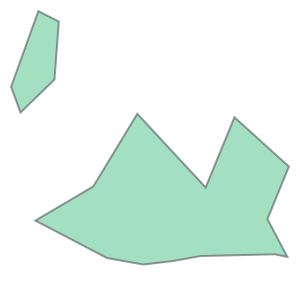

In [13]:
multi[8]

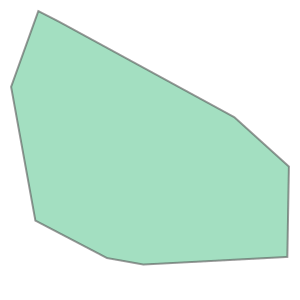

In [14]:
multi[8].convex_hull

### Geometric feature engineering

Now that I have a cleare picture of the data structure let's engineer a `convexness` feature.

**Requirements:**
- Be positively correlated with the `price_per_area`.
- Be constrained in the interval $[0, 1]$ (to work with normalized features). 

I propose the following definition of a parcel's _convexness_ :

$$convexness = 1 - \frac{\text{Area of the convex hull of the parcel} - \text{Area of the parcel}}{\text{Area of the convex hull of the parcel}}$$

If the parcel is convex, the area of its convex hull is equal to the area of the parcel, thus the fraction is equals to $0$ and $convexness=1$


For parcels with multiple sub-parcels (multiple polygons as seen in the example of `multi[8]`), the convex hull area is much bigger than the area of the parcel itself. Thus, the $convexness$ will decrease and belong to the the interval $[0, 1]$. 

---

I browse the geometry attribute of each parcel to get the polygon associated to the parcel. The `shapely` library provides us with all the tools needed to get an area from geospatial data.
Then,I evaluate the convexness with the formula shown previously.

In [174]:
convexness_measurement = []
with fiona.open('parcels_exam.shp') as raw_parcels_data:
    for parcel in raw_parcels_data:
        geometry = parcel['geometry']
        coords = geometry.get('coordinates')
        
        if geometry.get('type') == 'Polygon':
            polygon = Polygon(coords[0])  # index 0 because data is provided as a list with only one element
            
        if geometry.get('type') == 'MultiPolygon':
            polygons = []
            for shape in coords:
                polygons.append(Polygon(shape[0]))
            polygon = MultiPolygon(polygons)
        
        convexness = 1 - (polygon.convex_hull.area - polygon.area)/polygon.convex_hull.area
        convexness_measurement.append(convexness)
        
geo_series = {'convexness': convexness_measurement}
convexness = pd.DataFrame(geo_series, index=parcels_data.index)
parcels_data_with_convexness = pd.concat([parcels_data, convexness], axis=1, join_axes=[parcels_data.index])

A glance at the new dataframe

In [175]:
parcels_data_with_convexness.head(3)

_id           area     water   ponding   organic     slope       gdd  \
0  0.0  212202.777883  0.470132  0.716075  0.287991  0.383462  0.749170   
1  1.0  115054.634691  0.311945  0.398221  0.209844  0.186193  0.944372   
2  2.0  308655.040738  0.555649  0.009240  0.833038  0.984329  0.703495   

       road     tot_price  price_per_area  convexness  
0  0.878452  2.096351e+07           98.79    1.000000  
1  0.739551  6.928590e+06           60.22    0.536041  
2  0.181631  3.277608e+07          106.19    1.000000

## An estimator taking the parcel convexness into account

Now, I fit a linear regression model on the dataset on which we added the `convexness` feature to estimate the `price_per_area`. We compare the performance of the estimator with geomtric feature to the baseline estimator.



In [18]:
X = parcels_data_with_convexness.drop(['_id', 'price_per_area', 'tot_price'], axis=1)
X.area = (X.area - np.min(X.area))/(np.max(X.area) - np.min(X.area))
Y = parcels_data_with_convexness.price_per_area

In [181]:
convexness_mse = []
convexness_score = []

baseline_mse = []
baseline_score = []

# I iterate to test multiple train test split combinations
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_size)
    estimator_with_convexness = linear_model.LinearRegression()
    estimator_with_convexness.fit(X_train, y_train)
    y_pred = estimator_with_convexness.predict(X_test)

    # Compute the error of the model with geometric feature on top of the previous ones
    convexness_mse.append(mean_squared_error(y_test, y_pred))
    convexness_score.append(r2_score(y_test, y_pred))

    # We keep the same X and Y but drop the geometric feature
    X_train = X_train.loc[:, X_train.columns != 'convexness']
    X_test = X_test.loc[:, X_train.columns != 'convexness']
    baseline_estimator = linear_model.LinearRegression()
    baseline_estimator.fit(X_train, y_train)
    y_pred = baseline_estimator.predict(X_test)

    # Compute the error of the baseline model
    baseline_mse.append(mean_squared_error(y_test, y_pred))
    baseline_score.append(r2_score(y_test, y_pred))

score_increase = (np.mean(convexness_score) - np.mean(baseline_score))/np.mean(baseline_score)
print('Baseline estimator\n average MSE: %0.f \n average score: %0.03f' % (np.mean(baseline_mse), np.mean(baseline_score)))
print('\nEstimator with convexness feature added\n average MSE: %0.f \n average score: %0.03f' % (np.mean(convexness_mse), np.mean(convexness_score)))
print('\nScore increase: {0:.02%}'.format(score_increase))


Baseline estimator
 average MSE: 153 
 average score: 0.537

Estimator with convexness feature added
 average MSE: 151 
 average score: 0.545

Score increase: 1.41%


The model performance increases by 1 to 2 points when we add a measure of the parcel convexity in the features. 

This confirms the intuition from the `readme` file about convex parcels selling for a better price. Yet, it is not an extraordinary progression.
It is very likely that a different geometric feature choice could have had a larger impact. With the time allocated for the challenge I choose to continue to the next step. 

## (4) An estimator using land crop feature

Our objective is now to use the data from the raster file to add new features to train our estimator.

A parcel growing grapes, almonds, or walnuts sells to an higher price than a comparable parcel with other crops. We want to build a feature illustrating this phenomenon.

---

### CDL feature engineering

In a first approach, I consider `crop_rank` feature, which I define by:

$$ \text{crope_rank} = \frac{\text{number of pixels tagged with a high-value crop in the parcel}}{\text{total number of pixels defined in the parcel}}$$

We put a binary mask on the raster image to keep only the parcel of interest. On that parcel, we count the number of pixels that are tagged with a high-value crop. We divide that number by the total number of pixel in the parcel of interest.

If every pixel in the the parcel produces a high-value crop, then the parcel's `crope_rank` will be equal to $1$. On the other hand, if a parcel doesn't produce any high-value crop its `crope_rank` will be $0$. 

This feature is continous and belongs to the $[0, 1]$ interval. We expect `crope_rank` to be positively correlated to the `price_per_area`.

---

In a first time we need the cdl code corresponding to the high-value products.

In [62]:
cdl_code_table = pd.read_csv('cdl_mapping.csv')
reduced_code_table = cdl_code_table.loc[cdl_code_table['land_cover'].isin(['almonds', 'grapes', 'walnuts'])]
valuable_crops_code = list(reduced_code_table.cdl_code)

Now we can build the `crop_rank` feature

In [182]:
crope_rank_measurement = []

# First: Open the raster dataset
with rasterio.open('CDL_2017_clip_20180808132906_1114279202.tif') as cdl:
    
    # Then open the parcels shapefiles to get the polygon per parcel
    with fiona.open('parcels_exam.shp') as raw_parcels_data:
        for parcel in raw_parcels_data:
            geometry = parcel['geometry']
            coords = geometry.get('coordinates')

            if geometry.get('type') == 'Polygon':
                polygon = Polygon(coords[0])

            if geometry.get('type') == 'MultiPolygon':
                polygons = []
                for shape in coords:
                    polygons.append(Polygon(shape[0]))
                polygon = MultiPolygon(polygons)

            # Create mask on the zone of interest
            (masked_cdl, _) = rasterio.mask.mask(cdl, [polygon], crop=True)
            # Note that we crop the image and that 0 value pixels have been added 
            # We do no count 0 (undefined) pixels.
            
            unique_value, value_counts = np.unique(masked_cdl[0], return_counts=True)
            mask_data = dict(zip(unique_value, value_counts))
            
            num_pixels_parcels = sum([num_px for code, num_px in mask_data.items() if code != 0])
            num_pixels_valuable_product = sum([num_px for code, num_px in mask_data.items() if code in valuable_crops_code])
            
            # Compute crop_rank feature
            crop_rank = num_pixels_valuable_product/num_pixels_parcels
            crope_rank_measurement.append(crop_rank)

# Build a new dataset with the crop_rank feature
crop_rank_serie = {'crop_rank': crope_rank_measurement}
crop_rank = pd.DataFrame(crop_rank_serie, index=parcels_data.index)
parcels_data_with_crop_rank = pd.concat([parcels_data, crop_rank], axis=1, join_axes=[parcels_data.index])

### Linear regression with `crop_rank` as a feature

We will follow the same process that we used to compare the baseline and the geometric estimator.

First we will compare the crop estimator to the baseline, then to the geometric estimator.

Finally, we will build an estimator using `crop_rank` and `convexness` and compare it's performance to the baseline estimator

---

#### Crop estimator against the baseline estimator.


In [184]:
X = parcels_data_with_crop_rank.drop(['_id', 'price_per_area', 'tot_price'], axis=1)
X.area = (X.area - np.min(X.area))/(np.max(X.area) - np.min(X.area))
Y = parcels_data_with_crop_rank.price_per_area

In [185]:
cdl_mse = []
cdl_score = []

baseline_mse = []
baseline_score = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_size)
    
    estimator_with_cdl = linear_model.LinearRegression()
    estimator_with_cdl.fit(X_train, y_train)
    y_pred = estimator_with_cdl.predict(X_test)

    # Compute the error of the model with cdl
    cdl_mse.append(mean_squared_error(y_test, y_pred))
    cdl_score.append(r2_score(y_test, y_pred))


    X_train = X_train.loc[:, X_train.columns != 'crop_rank']
    X_test = X_test.loc[:, X_train.columns != 'crop_rank']
    baseline_estimator = linear_model.LinearRegression()
    baseline_estimator.fit(X_train, y_train)
    y_pred = baseline_estimator.predict(X_test)

    # Compute the error of the baseline model
    baseline_mse.append(mean_squared_error(y_test, y_pred))
    baseline_score.append(r2_score(y_test, y_pred))

score_increase = (np.mean(cdl_score) - np.mean(baseline_score))/np.mean(baseline_score)
print('Baseline estimator\n average MSE: %0.f \n average score: %0.03f' % (np.mean(baseline_mse), np.mean(baseline_score)))
print('\nEstimator with crop_rank feature added\n average MSE: %0.f \n average score: %0.03f' % (np.mean(cdl_mse), np.mean(cdl_score)))
print('\nScore increase: {0:.02%}'.format(score_increase))

Baseline estimator
 average MSE: 210 
 average score: 0.349

Estimator with crop_rank feature added
 average MSE: 156 
 average score: 0.515

Score increase: 47.58%


Compared to the baseline estimator, the estimator taking into account the kind of crop being cultivated on the soil is outperforming the baseline estimator with a more than 40% score increase. 

---

#### Crop estimator against the geometric estimator.

First we build a dataset with all the scalars features plus the features I crafted.


In [186]:
complete_parcels_data = pd.concat([parcels_data_with_crop_rank, convexness], axis=1, join_axes=[parcels_data_with_crop_rank.index])

In [187]:
X = complete_parcels_data.drop(['_id', 'price_per_area', 'tot_price'], axis=1)
X.area = (X.area - np.min(X.area))/(np.max(X.area) - np.min(X.area))
Y = complete_parcels_data.price_per_area

In [188]:
crop_mse = []
crop_score = []

geometry_mse = []
geometry_score = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_size)

    X_train = X_train.loc[:, X_train.columns != 'convexness']
    X_test = X_test.loc[:, X_train.columns != 'convexness']
    estimator_with_crop_rank = linear_model.LinearRegression()
    estimator_with_crop_rank.fit(X_train, y_train)
    y_pred = estimator_with_crop_rank.predict(X_test)

    # Compute the error of the model with crop_rank
    crop_mse.append(mean_squared_error(y_test, y_pred))
    crop_score.append(r2_score(y_test, y_pred))


    X_train = X_train.loc[:, X_train.columns != 'crop_rank']
    X_test = X_test.loc[:, X_train.columns != 'crop_rank']
    geometry_estimator = linear_model.LinearRegression()
    geometry_estimator.fit(X_train, y_train)
    y_pred = geometry_estimator.predict(X_test)

    # Compute the error of the geometry model
    geometry_mse.append(mean_squared_error(y_test, y_pred))
    geometry_score.append(r2_score(y_test, y_pred))

score_increase = (np.mean(crop_score) - np.mean(geometry_score))/np.mean(geometry_score)
print('Estimator with convexness feature added\n average MSE: %0.f \n average score: %0.03f' % (np.mean(geometry_mse), np.mean(geometry_score)))
print('\nEstimator with crop_rank feature added\n average MSE: %0.f \n average score: %0.03f' % (np.mean(crop_mse), np.mean(crop_score)))
print('\nScore increase: {0:.02%}'.format(score_increase))

Estimator with convexness feature added
 average MSE: 208 
 average score: 0.363

Estimator with crop_rank feature added
 average MSE: 153 
 average score: 0.529

Score increase: 45.85%


As expected we also find a score increase of more than 40% with the new estimator using the `crop_rank` feature.

---

#### Complete estimator against the baseline estimator.

We will now combine the shape data (`convexness`) and the crop value data (`crop_rank`) to build the best possible estimator and compare it to the baseline estimator. 



In [191]:
complete_mse = []
complete_score = []

baseline_mse = []
baseline_score = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-train_size)
    
    complete_estimator = linear_model.LinearRegression()
    complete_estimator.fit(X_train, y_train)
    y_pred = complete_estimator.predict(X_test)

    # Compute the error of the model with estimator using crop_rank and convexness
    complete_mse.append(mean_squared_error(y_test, y_pred))
    complete_score.append(r2_score(y_test, y_pred))


    X_train = X_train.drop(['crop_rank', 'convexness'], axis=1)
    X_test = X_test.drop(['crop_rank', 'convexness'], axis=1)
    baseline_estimator = linear_model.LinearRegression()
    baseline_estimator.fit(X_train, y_train)
    y_pred = baseline_estimator.predict(X_test)

    # Compute the error of the baseline model
    baseline_mse.append(mean_squared_error(y_test, y_pred))
    baseline_score.append(r2_score(y_test, y_pred))

score_increase = (np.mean(complete_score) - np.mean(baseline_score))/np.mean(baseline_score)
print('Baseline estimator\n average MSE: %0.f \n average score: %0.03f' % (np.mean(baseline_mse), np.mean(baseline_score)))
print('\nEstimator with crop_rank and convexness feature added\n average MSE: %0.f \n average score: %0.03f' % (np.mean(complete_mse), np.mean(complete_score)))
print('\nScore increase: {0:.02%}'.format(score_increase))

Baseline estimator
 average MSE: 212 
 average score: 0.353

Estimator with crop_rank and convexness feature added
 average MSE: 153 
 average score: 0.532

Score increase: 50.66%


This new estimator, using shape feature from the parcels and taking into account the product cultivated achieved an increase of 50% in the score compared to the baseline estimator. The fact that we cultivate or not a high-value product strongly influences the `price_per_area` prediction.

In [130]:
complete_estimator.coef_

array([17.63321581, 11.7373678 , 16.9536368 , 18.55615699, -3.28210479,
       10.76730107,  9.33810131, 20.59287452, 18.65326907])

Yet, when displaying this new estimator parameters', we notice that they are in the same order of magnitude. This is a good indicator that we are not over fitting the training dataset.

---

## Main take-aways

- Engineering simple features can have huge impacts on a model accuracy if this feature is catching the gist of a highly regarded market information.

- Even if the final estimator has much better results than the baseline, we are still at an approx. 50% $r^2$ score which is pretty low.

## Next Steps

- Crops related features extracted from the `.tif` are highly valuable data. Instead of building one feature, we could consider crafting as many features as their are products. Each feature would count the percentage of a given product per parcel.


